In [1]:
import pandas as pd
import os
import json
import torch
import numpy as np
from torch.utils.data import DataLoader
from steams.data import KVyQVx
from steams.models.transformer import Transf_enc_dec
from steams.trainer import AttentionTrainer,train, evaluation, prediction_prime, ensemble_prime
from steams.criterion import R2,RMSE,variance
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import geopandas as gpd

In [2]:
# parent_path = os.path.abspath(os.path.join(os.path.abspath(os.getcwd()), os.pardir))
# parent_dir = os.path.join(parent_path,'results','NWnn3')
# if not os.path.exists(parent_dir):
#     os.makedirs(parent_dir)

parent_dir = os.path.abspath(os.path.join(os.path.abspath(os.getcwd()), os.pardir))


In [3]:
resdir = os.path.join(parent_dir,'results')
figdir = os.path.join(parent_dir,'fig')
if not os.path.exists(figdir):
    os.makedirs(figdir)
if not os.path.exists(resdir):
    os.makedirs(resdir)

In [4]:
if torch.cuda.is_available():
    cuda_name = "1"
    num_workers=0
    pin_memory = True
    device = torch.device('cuda'+":"+cuda_name)
    #device = torch.device('cuda')
else:
    num_workers = 4
    pin_memory = False
    device = torch.device('cpu')

In [5]:
device

device(type='cpu')

## train/valid dataset

In [6]:
params = {
        "class" : "KVyQVx",
        "Y":{
          "path": "",
          "KEY":["x","y"],
          "VALUE": ["sensor_hq"],
          "nb_location" : 1000,
          "history_length": 0,
          "nb_sampling": 100
        },
        "X":{
          "path": "",
          "QUERY":["x","y"],
          "VALUE": ["sensor_hq"],
          "nb_location" : 1000,
          "gap_length": 0,
          "horizon_length":0,
          "nb_sampling": 100
        }
    }

In [7]:
params['Y']['path'] = os.path.join(parent_dir,"session","synth_1000_Y_train")
params['X']['path'] = os.path.join(parent_dir,"session","synth_1000_X_train")

train_dataset = KVyQVx(params)

In [8]:
params['Y']['path'] = os.path.join(parent_dir,"session","synth_1000_Y_valid")
params['X']['path'] = os.path.join(parent_dir,"session","synth_1000_X_valid")

valid_dataset = KVyQVx(params)

In [9]:
#train_dataset[0]

## model, optimizer, criterion, scheduler

In [10]:
#model
model = Transf_enc_dec(input_k=2,input_q=2, input_v=1, hidden_size=32,dim_feedforward=10,num_blk=2,dropout=0.1)

In [12]:
# optimzer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) #8e-3
#optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# criterion
criterion = torch.nn.MSELoss()

# AttentionTrainer object
obj = AttentionTrainer(model,device)
obj.init_optimizer(optimizer)
obj.init_criterion(criterion)

## Training

In [14]:
# training
train(obj,train_dataset,valid_dataset,niter=200,n_iter_stop=10,batch_size=64,shuffle=True,num_workers=num_workers,pin_memory=pin_memory,resdir=None)

  epoch     train     valid
0     0  0.100232  0.084226
  epoch     train     valid
0     1  0.099882  0.084546
  epoch     train     valid
0     2  0.100168  0.083809
  epoch     train    valid
0     3  0.099574  0.08387
  epoch    train     valid
0     4  0.09937  0.082586
  epoch     train     valid
0     5  0.099332  0.083011
  epoch     train     valid
0     6  0.098286  0.081953
  epoch    train     valid
0     7  0.09912  0.082548
  epoch     train    valid
0     8  0.098372  0.08201
  epoch     train     valid
0     9  0.098013  0.081156
  epoch     train     valid
0    10  0.096972  0.082488
  epoch     train     valid
0    11  0.097958  0.082093
  epoch     train    valid
0    12  0.097893  0.08111
  epoch     train     valid
0    13  0.097299  0.080009
  epoch     train     valid
0    14  0.096473  0.080999
  epoch     train     valid
0    15  0.096656  0.080718
  epoch     train     valid
0    16  0.096589  0.080913
  epoch     train    valid
0    17  0.095838  0.07998
  ep

In [15]:
enc_attention_weights = torch.cat(model.enc_transf.attention_weights, 0)

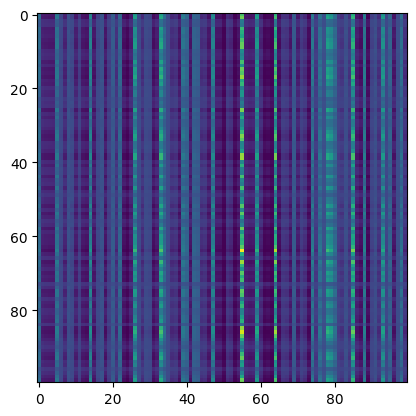

In [16]:
fig, ax = plt.subplots()
im = ax.imshow(enc_attention_weights[0])

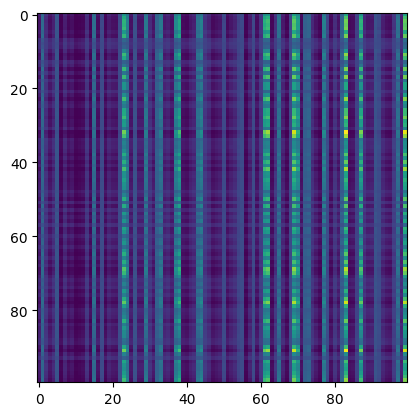

In [17]:
fig, ax = plt.subplots()
im = ax.imshow(enc_attention_weights[1])

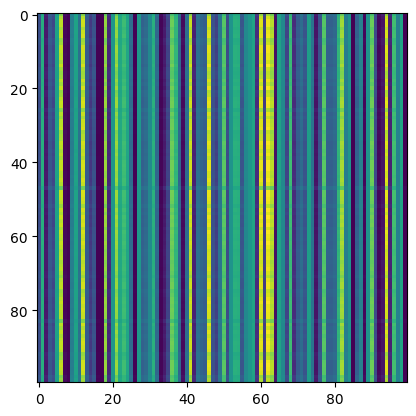

In [18]:
fig, ax = plt.subplots()
im = ax.imshow(model.cross_att.weights[0])

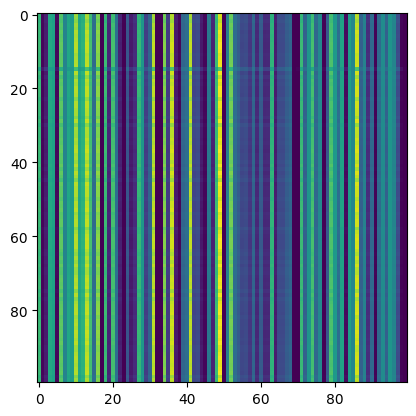

In [19]:
fig, ax = plt.subplots()
im = ax.imshow(model.cross_att.weights[1])

In [20]:
obj.save_model(resdir,"1e-transf_enc_dec")

## Or load model

In [21]:
obj.load_model(resdir,"1e-transf_enc_dec")

/home/jean-marie/dev/01-packages/steams_pkg/steams/trainer.py:265: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(model_path))


## Evaluation

In [22]:
params['Y']['path'] = os.path.join(parent_dir,"session","synth_1000_Y_eval")
params['X']['path'] = os.path.join(parent_dir,"session","synth_1000_X_eval")

eval_dataset = KVyQVx(params)

In [23]:
criterion = R2()
obj.init_criterion(criterion)

In [24]:
evaluation(obj,eval_dataset,batch_size=64,shuffle=True,num_workers=num_workers,pin_memory=pin_memory,resdir=None)

0.9026554115116596


In [25]:
criterion = RMSE()
obj.init_criterion(criterion)

In [26]:
evaluation(obj,eval_dataset,batch_size=64,shuffle=True,num_workers=num_workers,pin_memory=pin_memory,resdir=None)

36.24966740608215


In [27]:
criterion = variance()
obj.init_criterion(criterion)

In [28]:
evaluation(obj,eval_dataset,batch_size=64,shuffle=True,num_workers=num_workers,pin_memory=pin_memory,resdir=None)

642.6376724243164


## QQplot

In [29]:
params['Y']['path'] = os.path.join(parent_dir,"session","synth_1000_Y_eval")
params['X']['path'] = os.path.join(parent_dir,"session","synth_1000_X_eval")

eval_dataset = KVyQVx(params)

In [30]:
results = prediction_prime(obj,eval_dataset)

/home/jean-marie/dev/01-packages/steams_pkg/steams/trainer.py:163: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results,tmp_df],ignore_index=True,axis=0)


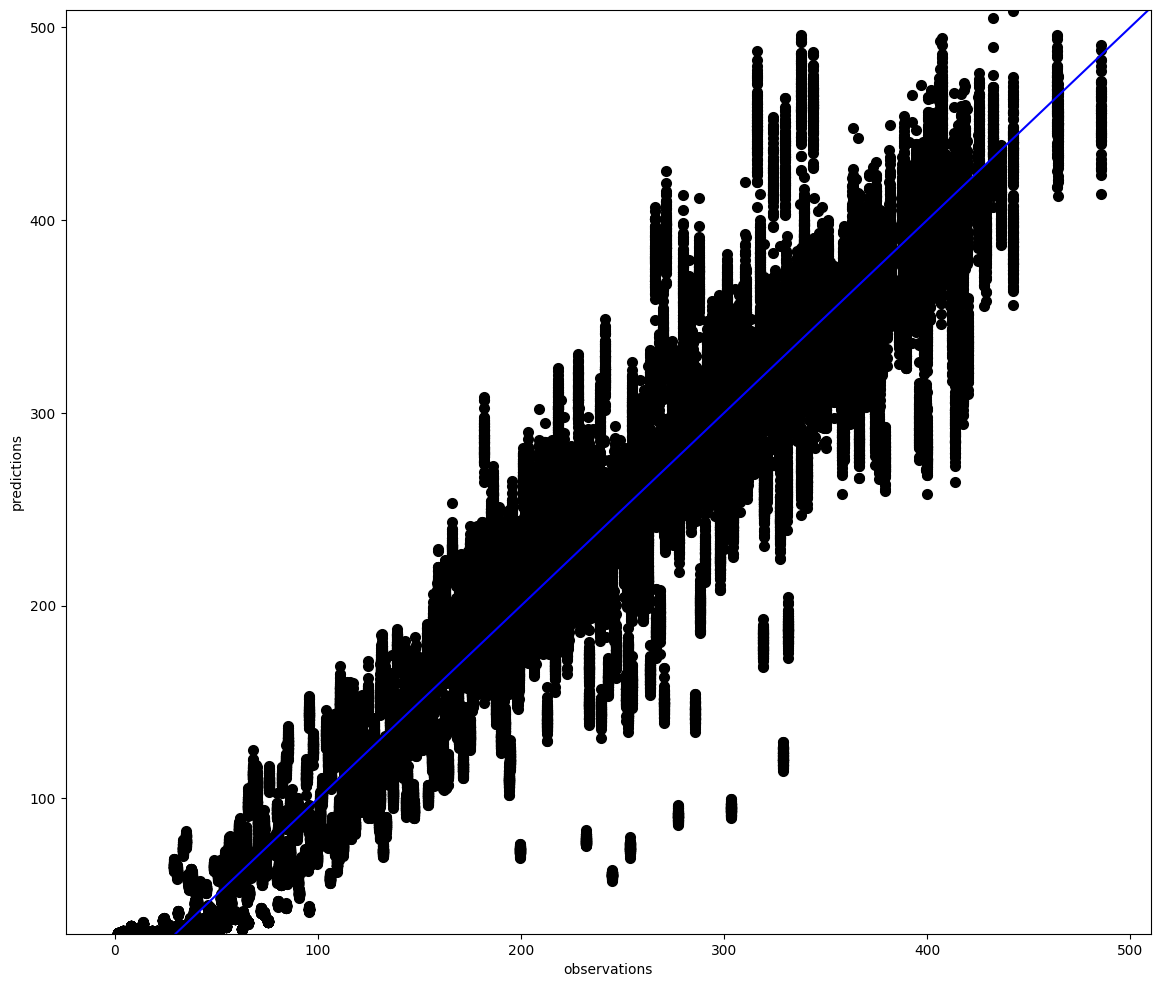

In [31]:
pred_name = ['pred_' + v for v in eval_dataset.VALUE_X]

fig, ax= plt.subplots(figsize=(14, 12))
ax.scatter(results.loc[:,eval_dataset.VALUE_X],results.loc[:,pred_name], linewidth=2.0,c="black")
ax.axline((0, 0), slope=1., color='blue')
# ax.set_xlim(0, 2.5)
ax.set_ylim(results.loc[:,pred_name].min().item()-0.5, results.loc[:,pred_name].max().item()+0.5)
ax.set(xlabel='observations', ylabel='predictions')

fig_filename = os.path.join(parent_dir,'fig','1c-qqplot.png')
plt.savefig(fig_filename, dpi = 300)